In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(tsibble))
suppressMessages(library(fable))
suppressMessages(library(tsibble))
suppressMessages(library(fabletools))
suppressMessages(library(feasts))
suppressMessages(library(lubridate))
suppressMessages(library(scales))
suppressMessages(library(fpp3))
suppressMessages(library(gridExtra))
suppressMessages(library(Mcomp))

Warning message:
"package 'ggplot2' was built under R version 4.3.2"
Warning message:
"package 'Mcomp' was built under R version 4.3.3"


## Practical Issues

### Outliers

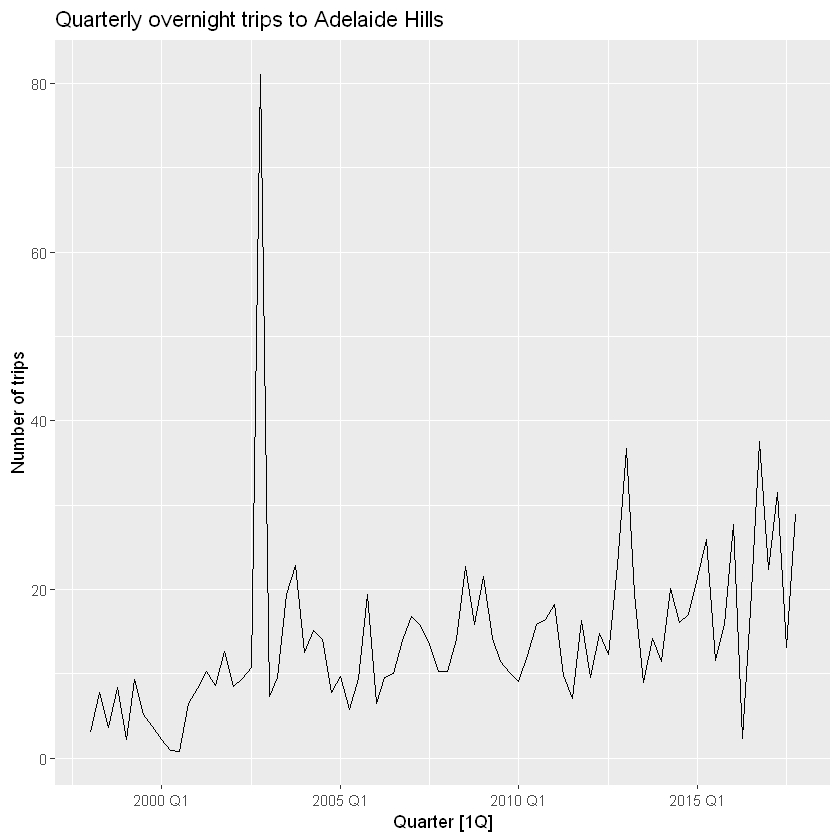

In [2]:
tourism |>
  filter(
    Region == "Adelaide Hills", Purpose == "Visiting"
  ) |>
  autoplot(Trips) +
  labs(title = "Quarterly overnight trips to Adelaide Hills",
       y = "Number of trips")

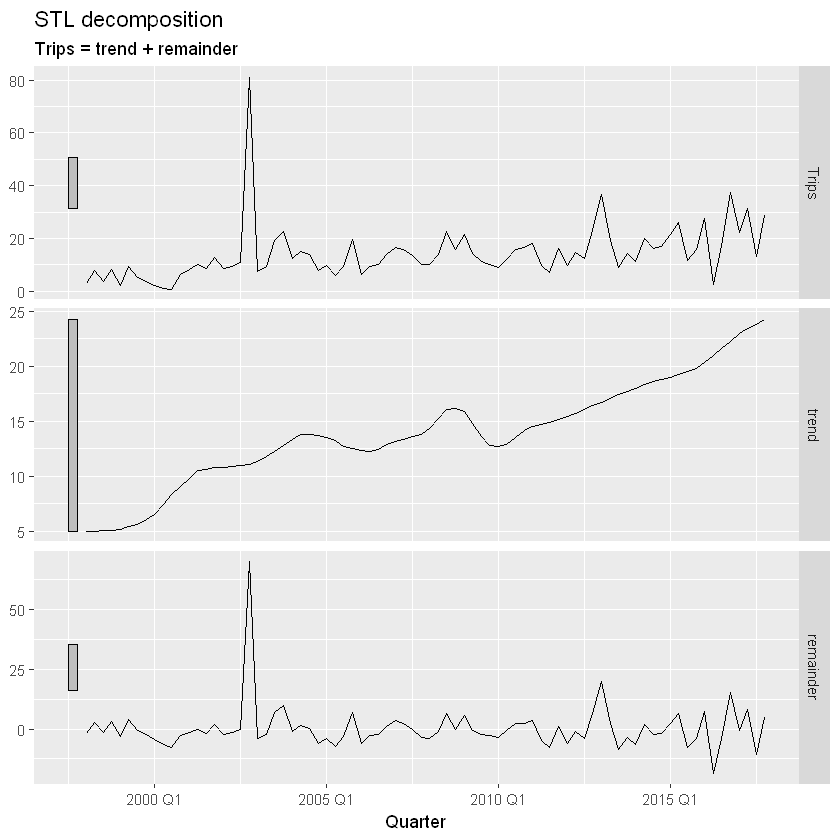

In [3]:
ah_decomp <- tourism |>
  filter(
    Region == "Adelaide Hills", Purpose == "Visiting"
  ) |>
  # Fit a non-seasonal STL decomposition
  model(
    stl = STL(Trips ~ season(period = 1), robust = TRUE)
  ) |>
  components()
ah_decomp |> autoplot()

In [4]:
outliers <- ah_decomp |>
  filter(
    remainder < quantile(remainder, 0.25) - 3*IQR(remainder) |
    remainder > quantile(remainder, 0.75) + 3*IQR(remainder)
  )
outliers

Region,State,Purpose,.model,Quarter,Trips,trend,remainder,season_adjust
<chr>,<chr>,<chr>,<chr>,<qtr>,<dbl>,<dbl>,<dbl>,<dbl>
Adelaide Hills,South Australia,Visiting,stl,2002 Q4,81.10211,11.11922,69.98289,81.10211


### Replacing Outliers or Missing Data

In [5]:
ah_miss <- tourism |>
  filter(
    Region == "Adelaide Hills",
    Purpose == "Visiting"
  ) |>
  # Remove outlying observations
  anti_join(outliers) |>
  # Replace with missing values
  fill_gaps()

ah_miss %>% filter_index('2002 Q1' ~ '2003 Q2')

Joining with `by = join_by(Quarter, Region, State, Purpose, Trips)`


Quarter,Region,State,Purpose,Trips
<qtr>,<chr>,<chr>,<chr>,<dbl>
2002 Q1,Adelaide Hills,South Australia,Visiting,8.499523
2002 Q2,Adelaide Hills,South Australia,Visiting,9.475336
2002 Q3,Adelaide Hills,South Australia,Visiting,10.776378
2002 Q4,Adelaide Hills,South Australia,Visiting,NA
2003 Q1,Adelaide Hills,South Australia,Visiting,7.326994
2003 Q2,Adelaide Hills,South Australia,Visiting,9.511389


In [6]:
ah_fill <- ah_miss |>
  # Fit ARIMA model to the data containing missing values
  model(ARIMA(Trips)) |>
  # Estimate Trips for all periods
  interpolate(ah_miss)

ah_fill %>% filter_index('2002 Q1' ~ '2003 Q2')

Region,State,Purpose,Quarter,Trips
<chr>,<chr>,<chr>,<qtr>,<dbl>
Adelaide Hills,South Australia,Visiting,2002 Q1,8.499523
Adelaide Hills,South Australia,Visiting,2002 Q2,9.475336
Adelaide Hills,South Australia,Visiting,2002 Q3,10.776378
Adelaide Hills,South Australia,Visiting,2002 Q4,8.495345
Adelaide Hills,South Australia,Visiting,2003 Q1,7.326994
Adelaide Hills,South Australia,Visiting,2003 Q2,9.511389


Then model with the filled data

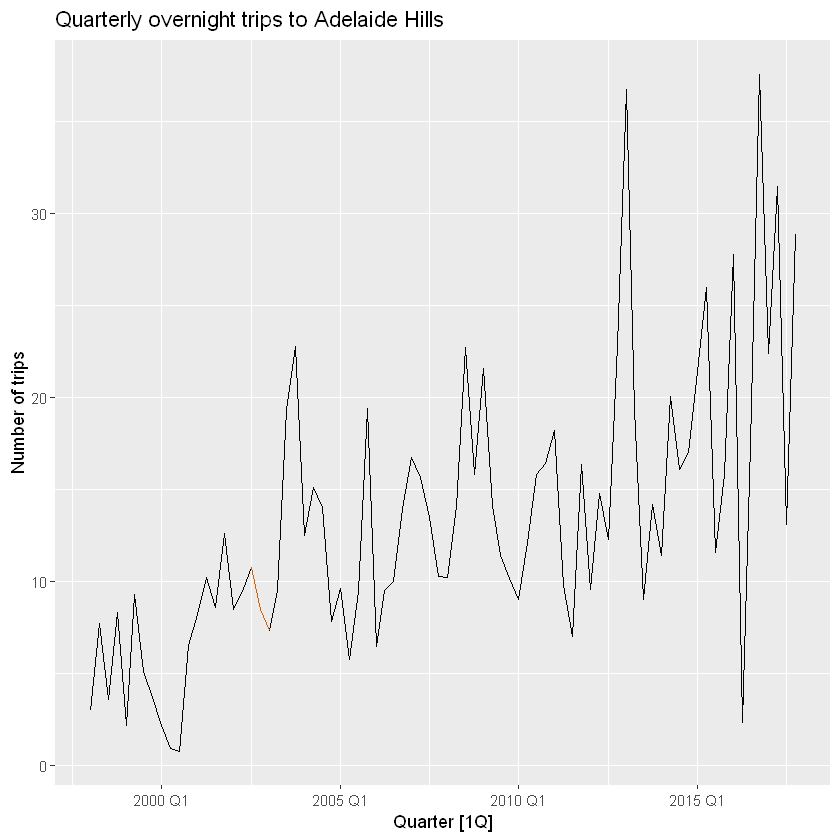

In [7]:
ah_fill |>
  autoplot(Trips) +
  autolayer(ah_fill |> filter_index("2002 Q3"~"2003 Q1"),
    Trips, colour="#D55E00") +
  labs(title = "Quarterly overnight trips to Adelaide Hills",
       y = "Number of trips")

### Very Short Time Series

In [ ]:
m3totsibble <- function(z) {
  bind_rows(
    as_tsibble(z$x) |> mutate(Type = "Training"),
    as_tsibble(z$xx) |> mutate(Type = "Test")
  ) |>
    mutate(
      st = z$st,
      type = z$type,
      period = z$period,
      description = z$description,
      sn = z$sn
    ) |>
    as_tibble()
}

short <- Mcomp::M3 |>
  subset("yearly") |>
  purrr::map_dfr(m3totsibble) |>
  group_by(sn) |>
  mutate(n = max(row_number())) |>
  filter(n <= 20) |>
  ungroup() |>
  as_tsibble(index = index, key = c(sn, period, st))

In [ ]:
short_fit <- short |>
  model(arima = ARIMA(value))

In [ ]:
short_fit %>% head(10)

### Missing Values

In [ ]:
high_yield_bond_tr <- read.csv('data/BAMLHYH0A0HYM2TRIV.csv')
high_yield_bond_tr %>% head()

Convert to a tsibble and perform assessment of missing values.

In [ ]:
high_yield_bond_tr <- high_yield_bond_tr %>%
rename(RETURN_INDEX = BAMLHYH0A0HYM2TRIV) %>%
mutate(RETURN_INDEX = as.numeric(RETURN_INDEX)) %>%
mutate(DATE = ymd(as.Date(DATE))) %>%
as_tsibble(index=DATE)

high_yield_bond_tr %>% head()

Explicit Missing Values

In [ ]:
high_yield_bond_tr %>%
filter(is.na(RETURN_INDEX)) %>%
head()

Implicit Missing Values

In [ ]:
high_yield_bond_tr %>% scan_gaps() %>% head()

In [ ]:
high_yield_bond_tr <- high_yield_bond_tr %>%
fill_gaps()

high_yield_bond_tr %>% head()

### Modeling Counts
- Discussed models assume the data is continuous.  
- Often data is of counts, e.g., number of products sold, number of people, and the result could only be integers.  
- Generally doesn't matter if the counts are somewhat large, e.g., above 100.  
- For smaller counts, assuming the data is continuous could have implications on forecasting performance.  
- Also need to constrain the forecasts to be positive, i.e., cannot have negative people.
- A method is `Croston's method`, which is really an approximation of count data rather than explicitly a method for handling count data.

Croston's Method:
- Construct two new series $\alpha$ and $q$, where $q_i$ is the ***i***th quantity of non-zero counts and $\alpha_i$ is the time between $q_i$ and $q_{i+1}$.  
- Separate exponential smoothing forecasts for each new series.  
- Usually applied to timing of demand and demand for items.

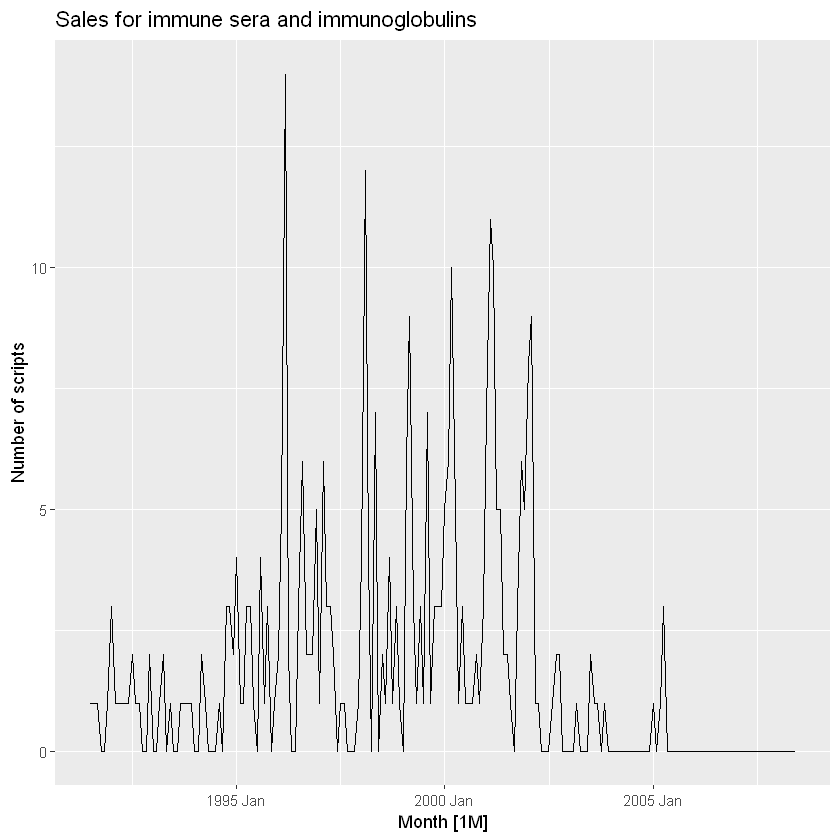

In [8]:
j06 <- PBS |>
  filter(ATC2 == "J06") |>
  summarise(Scripts = sum(Scripts))

j06 |> autoplot(Scripts) +
  labs(y="Number of scripts",
       title = "Sales for immune sera and immunoglobulins")

In [9]:
j06_croston <- j06 |>
  model(CROSTON(Scripts))

j06_croston

CROSTON(Scripts)
<model>
<croston>


In [10]:
j06_croston %>% forecast(h=12)

.model,Month,Scripts,.mean
<chr>,<mth>,<dist>,<dbl>
CROSTON(Scripts),2008 Jul,0.9735062,0.9735062
CROSTON(Scripts),2008 Aug,0.9735062,0.9735062
CROSTON(Scripts),2008 Sep,0.9735062,0.9735062
CROSTON(Scripts),2008 Oct,0.9735062,0.9735062
CROSTON(Scripts),2008 Nov,0.9735062,0.9735062
CROSTON(Scripts),2008 Dec,0.9735062,0.9735062
CROSTON(Scripts),2009 Jan,0.9735062,0.9735062
CROSTON(Scripts),2009 Feb,0.9735062,0.9735062
CROSTON(Scripts),2009 Mar,0.9735062,0.9735062


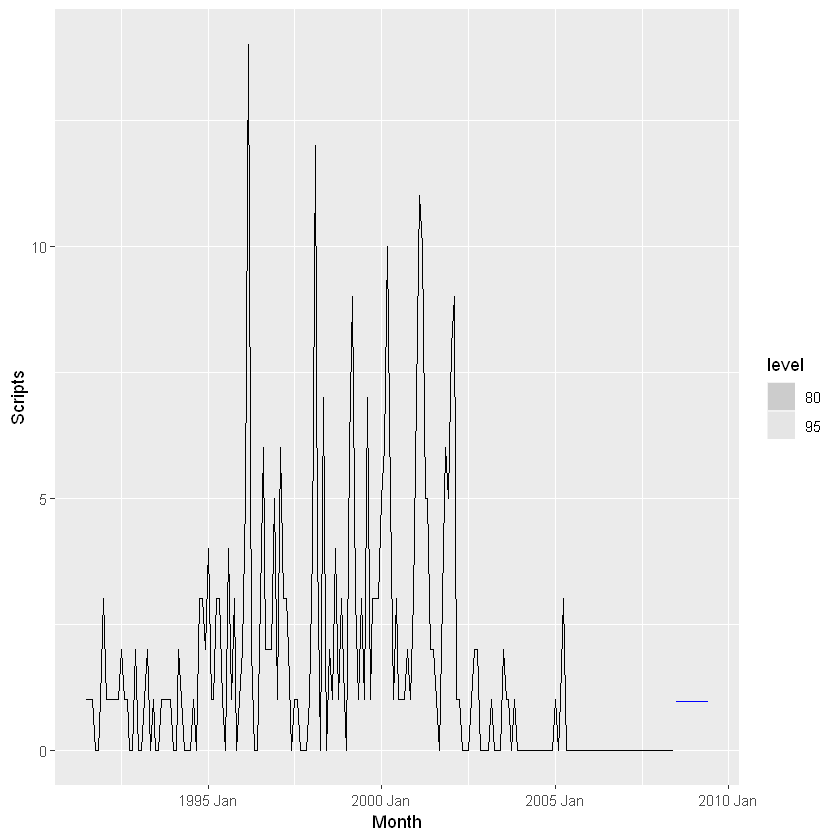

In [11]:
j06_croston %>% forecast(h=12) %>% autoplot(j06)

### Constraining Forecasts to a Range

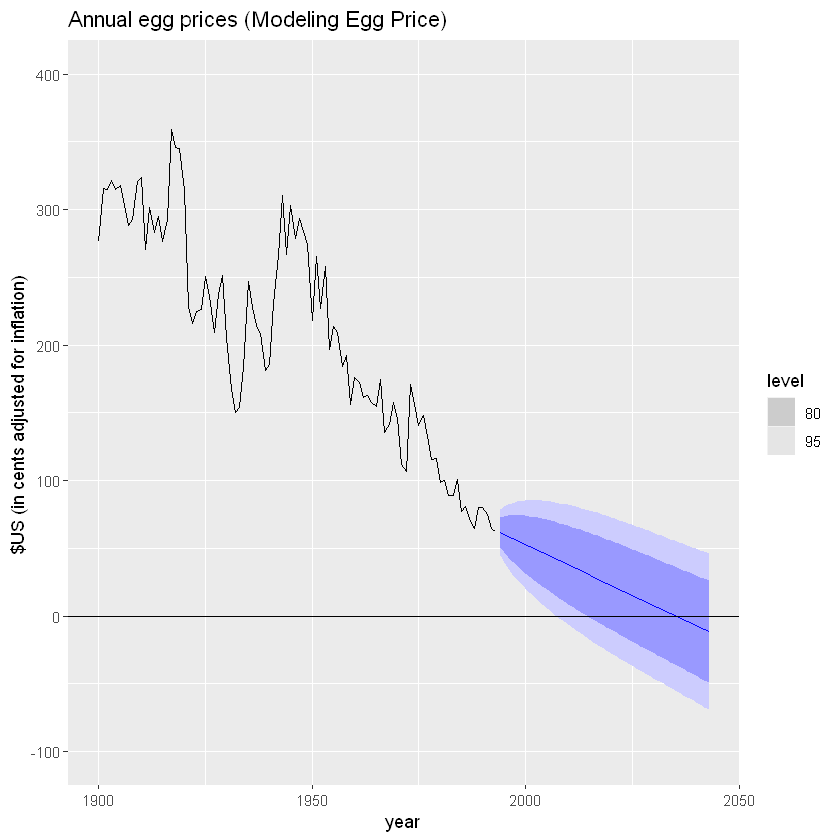

In [12]:
egg_prices <- prices |> filter(!is.na(eggs))
egg_prices |>
  model(ETS(eggs ~ trend("A"))) |>
  forecast(h = 50) |>
  autoplot(egg_prices) +
  geom_hline(yintercept = 0) +
  ylim(-100, 400) +
  labs(title = "Annual egg prices (Modeling Egg Price)",
       y = "$US (in cents adjusted for inflation) ")

Model the log to avoid the issue.

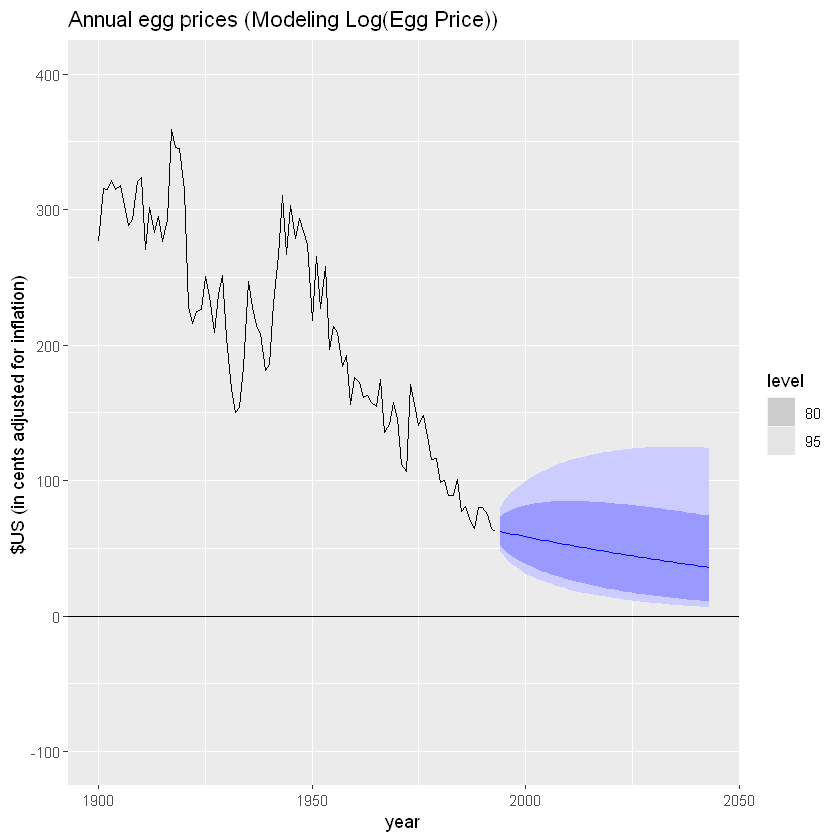

In [13]:
egg_prices <- prices |> filter(!is.na(eggs))
egg_prices |>
  model(ETS(log(eggs) ~ trend("A"))) |>
  forecast(h = 50) |>
  autoplot(egg_prices) +
  geom_hline(yintercept = 0) +
  ylim(-100, 400) +
  labs(title = "Annual egg prices (Modeling Log(Egg Price))",
       y = "$US (in cents adjusted for inflation) ")

To constrain, need a custom function

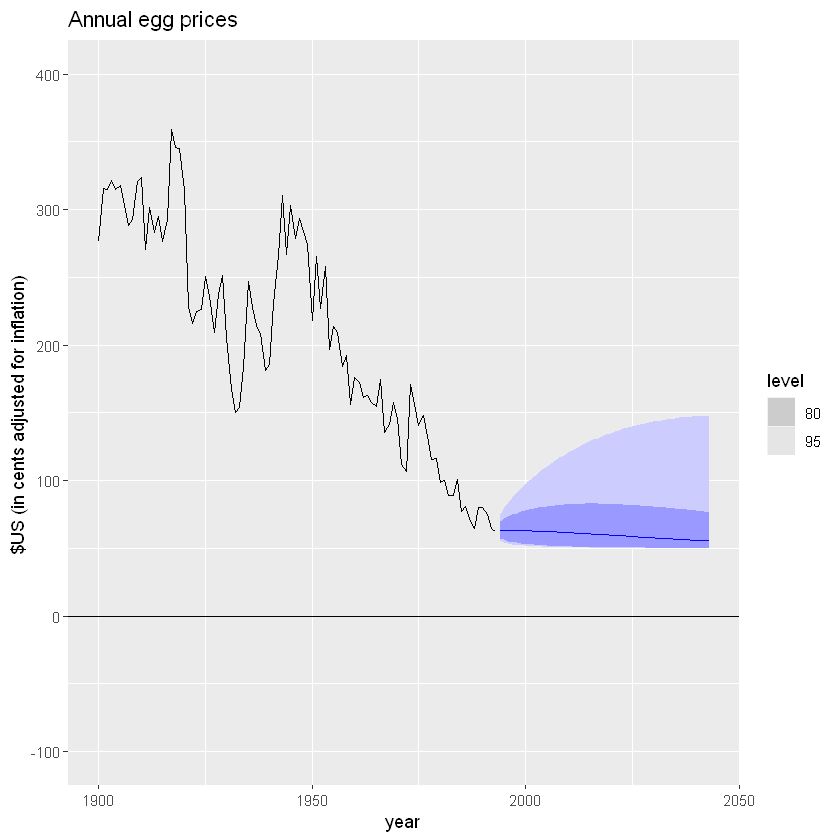

In [14]:
scaled_logit <- function(x, lower = 0, upper = 1) {
  log((x - lower) / (upper - x))
}
inv_scaled_logit <- function(x, lower = 0, upper = 1) {
  (upper - lower) * exp(x) / (1 + exp(x)) + lower
}
my_scaled_logit <- new_transformation(
                    scaled_logit, inv_scaled_logit)

egg_prices |>
  model(
    ETS(my_scaled_logit(eggs, lower = 50, upper = 400)
          ~ trend("A"))
  ) |>
  forecast(h = 50) |>
  autoplot(egg_prices) +
  geom_hline(yintercept = 0) +
  ylim(-100, 400) +
  labs(title = "Annual egg prices",
       y = "$US (in cents adjusted for inflation) ")

$y = log(\frac{x-50}{400-x})$

$x = \frac{(400 - 50)e^{y}}{1+e^{y}} + 50$

### Forecast Combinations
Monthly revenue from restarants in Australia.

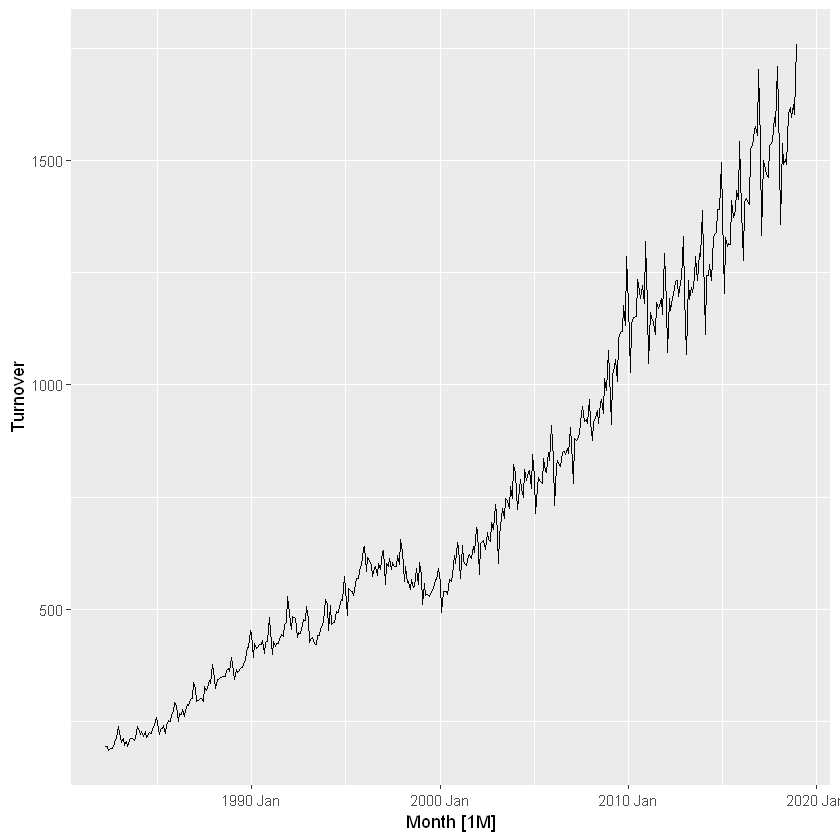

In [15]:
auscafe <- aus_retail |>
  filter(stringr::str_detect(Industry, "Takeaway")) |>
  summarise(Turnover = sum(Turnover))

auscafe %>% autoplot(Turnover)

Warning message:
"Removed 1 row containing missing values (`geom_line()`)."


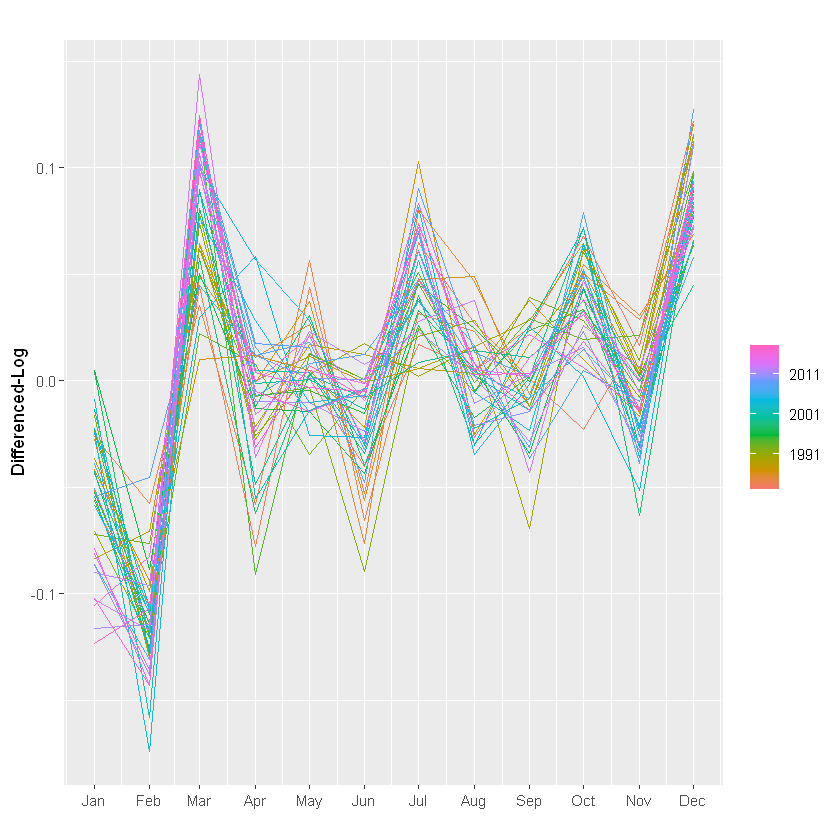

In [16]:
auscafe %>% gg_season(difference(log(Turnover))) + labs(title='', y='Differenced-Log', x='')

In [17]:
train <- auscafe |>
  filter(year(Month) <= 2013)

In [19]:
STLF <- decomposition_model(
  STL(log(Turnover) ~ season(window = Inf)),
  ETS(season_adjust ~ season("N"))
)

In [20]:
cafe_models <- train |>
  model(
    ets = ETS(Turnover),
    stlf = STLF,
    arima = ARIMA(log(Turnover))
  ) |>
  mutate(combination = (ets + stlf + arima) / 3)

cafe_models

ets,stlf,arima,combination
<model>,<model>,<model>,<model>
"<ETS(M,Ad,M)>",<STL decomposition model>,"<ARIMA(1,1,0)(2,1,2)[12]>",<COMBINATION>


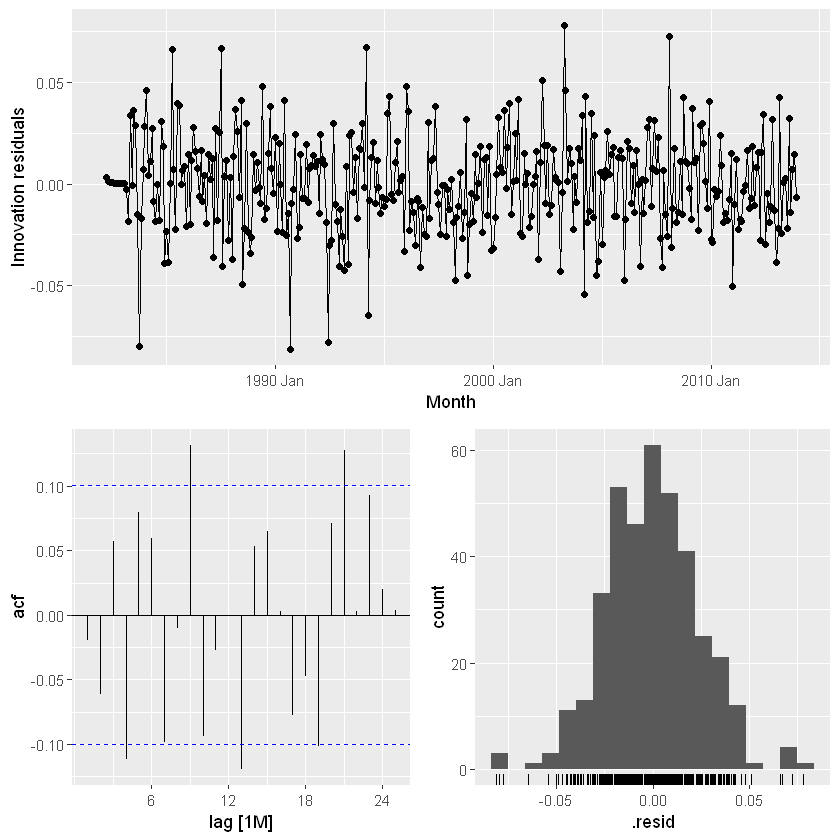

In [21]:
cafe_models %>% select(arima) %>% gg_tsresiduals()

Warning message:
"Removed 12 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 12 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 12 rows containing non-finite values (`stat_bin()`)."


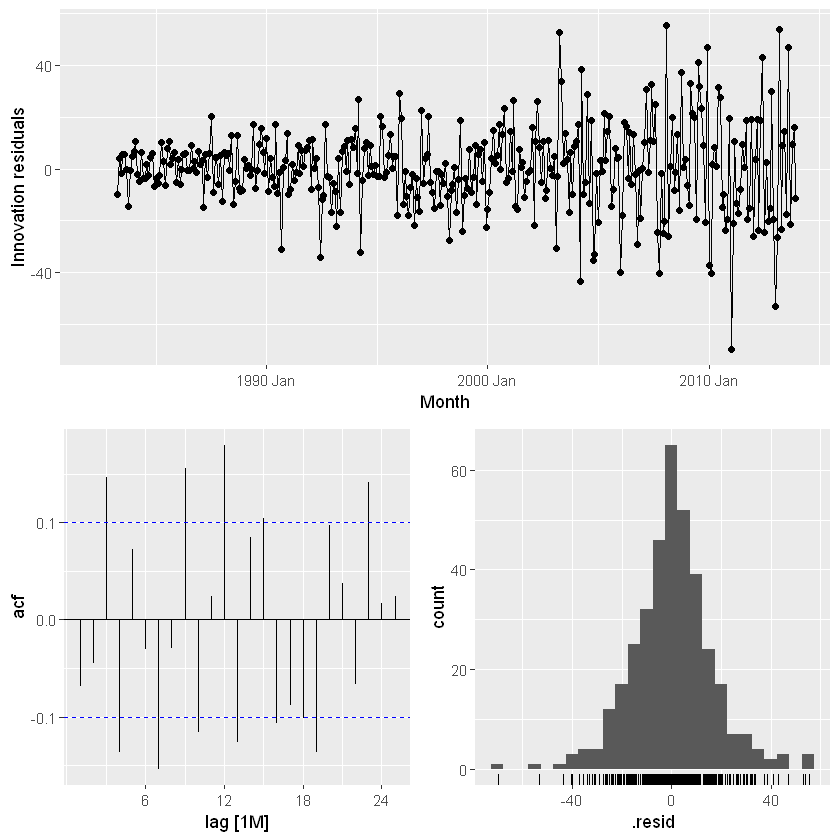

In [22]:
cafe_models %>% select(combination) %>% gg_tsresiduals()

In [23]:
cafe_models %>%
fabletools::accuracy() %>%
select(.model, RMSE, MAPE)

.model,RMSE,MAPE
<chr>,<dbl>,<dbl>
ets,17.42304,1.988403
stlf,17.35916,1.972896
arima,16.07880,1.892019
combination,16.29983,1.874418


Smaller MAPE due to large misses on ARIMA being smoothed by the other models.

In [24]:
cafe_fc <- cafe_models |>
  forecast(h = "5 years")

In [25]:
cafe_fc |>
  fabletools::accuracy(auscafe) |>
  select(.model, RMSE, MAPE) %>%
  arrange(RMSE)

.model,RMSE,MAPE
<chr>,<dbl>,<dbl>
combination,41.02526,2.189962
arima,46.24214,2.654548
stlf,64.08230,3.541498
ets,122.05610,6.664271


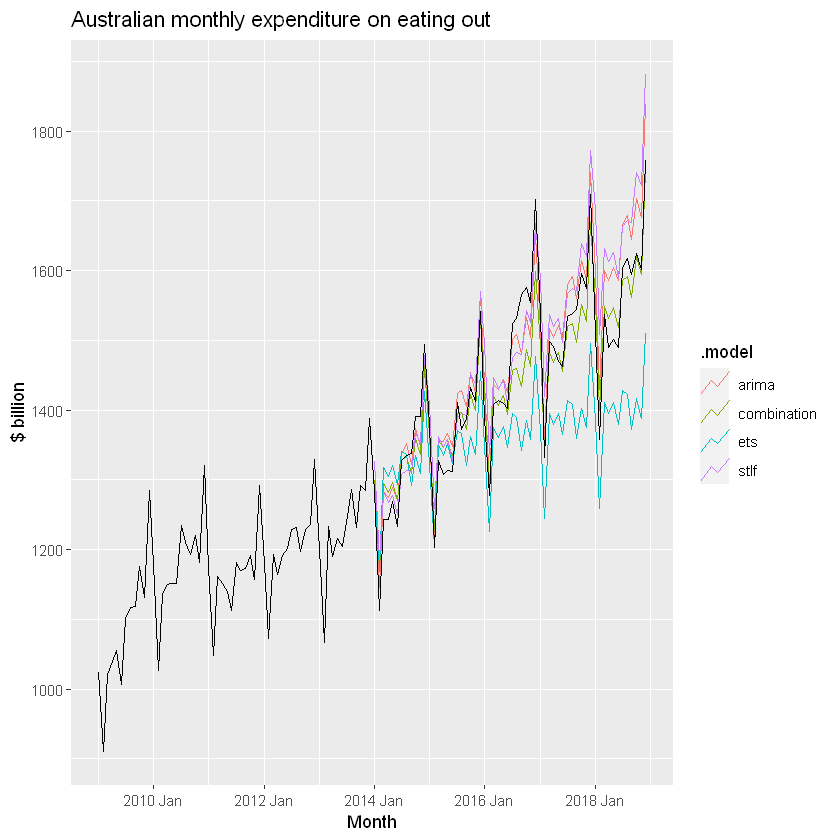

In [26]:
cafe_fc |>
  autoplot(auscafe |> filter(year(Month) > 2008),
           level = NULL) +
  labs(y = "$ billion",
       title = "Australian monthly expenditure on eating out")

#### Calculating the Prediction Intervals

In [27]:
cafe_fc |> filter(Month == min(Month))

.model,Month,Turnover,.mean
<chr>,<mth>,<dist>,<dbl>
ets,2014 Jan,"N(1289, 1118)",1289.058
stlf,2014 Jan,"t(N(7.2, 0.00063))",1326.188
arima,2014 Jan,"t(N(7.2, 0.00061))",1282.894
combination,2014 Jan,1299.38,1299.380


- Notice the distributions are different (normal, transformed-normal)
- Will need to simulate to calculate the intervals


In [28]:
cafe_futures <- cafe_models |>
  # Generate 1000 future sample paths
  generate(h = "5 years", times = 1000) |>
  # Compute forecast distributions from future sample paths
  as_tibble() |>
  group_by(Month, .model) |>
  summarise(
    dist = distributional::dist_sample(list(.sim))
  ) |>
  ungroup() |>
  # Create fable object
  as_fable(index = Month, key = .model,
           distribution = dist, response = "Turnover")

cafe_futures |> filter(Month == min(Month)) 

`summarise()` has grouped output by 'Month'. You can override using the
`.groups` argument.
Warning message:
"The dimnames of the fable's distribution are missing and have been set to match the response variables."


Month,.model,dist
<mth>,<chr>,<dist>
2014 Jan,arima,sample[1000]
2014 Jan,combination,sample[1000]
2014 Jan,ets,sample[1000]
2014 Jan,stlf,sample[1000]


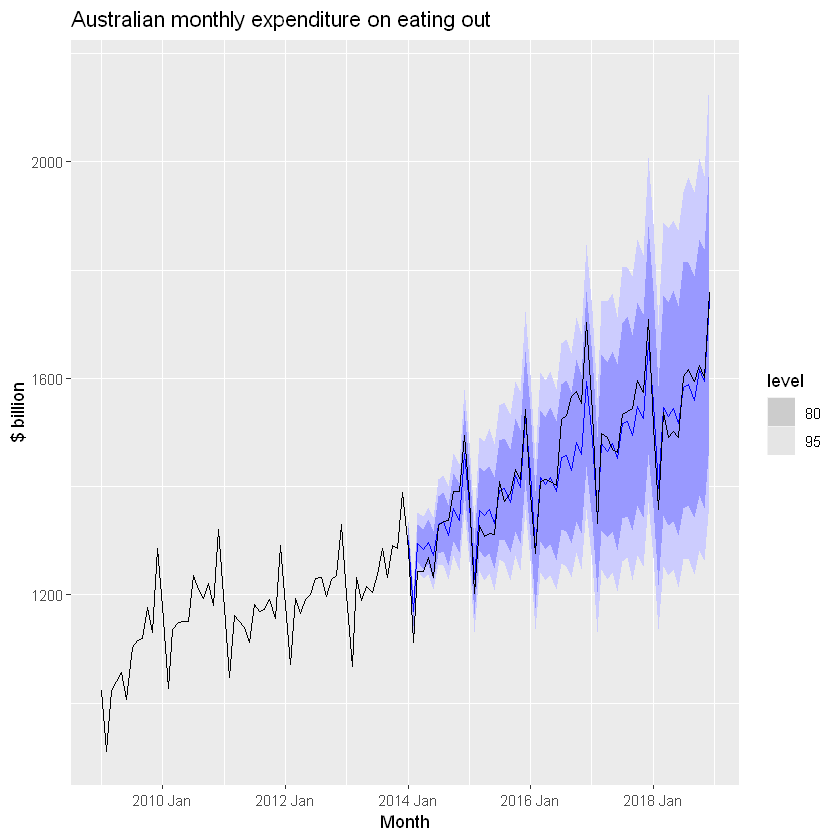

In [29]:
cafe_futures |>
  filter(.model == "combination") |>
  autoplot(auscafe |> filter(year(Month) > 2008)) +
  labs(y = "$ billion",
       title = "Australian monthly expenditure on eating out")